# Model Evaluation

This tutorial steps through the model evaluation process.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from tabulate import tabulate
import torch

print("Torch  Version", torch.__version__)

Torch  Version 1.10.2+cu102


In [2]:
from vpower.src.utils.auxiliary_functions import load_data_and_set_index
from vpower.src.utils.assessment import calc_uncertainty_regection_curve, f_beta_metrics, get_ensemble_errors, get_ensemble_metric
from vpower.src.utils.uncertainty import ensemble_uncertainties_regression
from vpower.src.utils.plot_utils import get_comparison_error_retention_plot, get_comparison_f1_retention_plot
from vpower.src.utils.scaler import FeatureScaler
from vpower.src.models.mc_dropout import *

In [3]:
# Optional: Customize the plots configuration
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=30)

# Load data

This tutorial assumes that all data files are placed in a local directory named `../datasets/`.

In [4]:
data_dir = "../datasets/"

In [6]:
# Load data partitions and assign them to dictionary datasets
data_all = {}

for partition in ["train", "dev_in", "dev_out"]:
    df = load_data_and_set_index(filepath=data_dir + f"{partition}.csv", index_column_name="time_id")
    data_all[partition] = df

data_all["dev"] = pd.concat([data_all["dev_in"], data_all["dev_out"]])

In [7]:
print("Number of records per dataset type:" + "\n")
for k in data_all.keys():
    print(f"{k}: ", data_all[k].shape[0])

Number of records per dataset type:

train:  530706
dev_in:  18368
dev_out:  18368
dev:  36736


# Data scaling

In [8]:
input_features = ["draft_aft_telegram",
                  "draft_fore_telegram",

                  "stw",
                  "diff_speed_overground",

                  "awind_vcomp_provider",
                  "awind_ucomp_provider",
                  "rcurrent_vcomp",
                  "rcurrent_ucomp",
                  "comb_wind_swell_wave_height",

                  "timeSinceDryDock",
                  ]

target = "power"

scaling_config = {target: "zeta",
                  "draft_aft_telegram": "zeta",
                  "draft_fore_telegram": "zeta",
                  "stw": "zeta",
                  "diff_speed_overground": "zeta",
                  "awind_vcomp_provider": "zeta",
                  "awind_ucomp_provider": "zeta",
                  "rcurrent_vcomp": "zeta",
                  "rcurrent_ucomp": "zeta",
                  "comb_wind_swell_wave_height": "zeta",
                  "timeSinceDryDock": "time"}

In [9]:
scaler = FeatureScaler(config=scaling_config)
scaler.fit(data_all["train"])

data_all_ds = {}
for k in data_all.keys():
    data_all_ds[k] = VPowerDataset(data=data_all[k],
                                   scaler=scaler,
                                   input_features=input_features,
                                   target=target)

In [10]:
data_all_ds["train"].norm_df.describe()

,power,draft_aft_telegram,draft_fore_telegram,stw,diff_speed_overground,awind_vcomp_provider,awind_ucomp_provider,rcurrent_vcomp,rcurrent_ucomp,comb_wind_swell_wave_height,timeSinceDryDock
count,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,5.307060e+05,530706.000000
mean,1.011109e-16,-1.792227e-11,6.768778e-12,-2.022219e-16,-7.410876e-16,-1.581787e-14,4.059819e-14,-2.819110e-16,-7.454790e-17,2.773867e-14,0.224662
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.105628
min,-2.372240e+00,-3.048429e+00,-3.503600e+00,-4.201170e+00,-1.183390e+01,-3.245963e+00,-1.320819e+00,-4.246077e+00,-5.791053e+00,-1.807258e+00,0.002492
25%,-9.651075e-01,-7.589000e-01,-7.674321e-01,-7.325259e-01,-5.351493e-01,-7.487325e-01,-8.111294e-01,-4.072123e-01,-4.385619e-01,-6.912824e-01,0.149662
50%,2.860689e-01,2.166385e-01,2.406296e-01,3.744020e-01,-2.747418e-03,-2.102703e-02,-2.452139e-01,1.641387e-02,-1.809511e-02,-1.126555e-01,0.237851
75%,6.925896e-01,7.674528e-01,8.166648e-01,6.764622e-01,5.888102e-01,7.463498e-01,6.283914e-01,4.111297e-01,4.229756e-01,5.613785e-01,0.314234
max,2.773026e+00,1.630174e+00,1.565511e+00,2.250746e+00,1.182840e+01,2.728355e+00,2.864781e+00,4.208834e+00,5.817410e+00,4.369962e+00,0.401345


# Load models

This tutorial assumes that the trained models are located in a local directory named `../my_models/ens_mc_dropout/`.

In [11]:
# Model directory
model_dir = "../my_models/ens_mc_dropout"

The ensemble MC dropout consists of 10 probabilistic MC dropout neural networks that have the same structure but trained with different parameters' initialization.

In [12]:
loaded_models = []

for i in range(1, 11):
    model = ProbMCdropoutDNN(input_size=len(input_features),
                             hidden_size_1=50,
                             hidden_size_2=20,
                             dropout=0.005)
    load_path = os.path.join(model_dir, f"member_{i}", "best_model.pth")
    load_model(model=model, path=load_path)
    loaded_models.append(model)

During inference, each member of the ensemble is sampled 10 times (multi_runs=10) to capture the epistemic uncertainty due to the stochasticity of the single model’s parameters).

In [13]:
predictions = {}

for k in data_all_ds.keys():
    predictions[k] = {}
    inputs = torch.tensor(data_all_ds[k].items).float()
    preds_norm = get_ensemble_predictions(model_list=loaded_models,
                                          data_norm=inputs,
                                          multi_runs=10)
    predictions[k]["norm"] = preds_norm

    # Denormalize predicted mean
    preds_denorm = preds_norm.copy()
    preds_denorm[:, :, 0] = scaler.inverse_transform(preds_norm[:, :, 0], feature=target)
    preds_denorm[:, :, 1] = preds_norm[:, :, 1] * np.square(scaler.std[target])
    predictions[k]["denorm"] = preds_denorm

100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


In [14]:
uncertainties = {}
for k in data_all_ds.keys():
    uncertainties[k] = ensemble_uncertainties_regression(preds=predictions[k]["denorm"])

In [15]:
sqr_errors = {}
for k in data_all_ds.keys():
    sqr_errors[k] = get_ensemble_errors(predictions=predictions[k]["denorm"],
                                        y_true=data_all_ds[k].full_df[target])

# Retention curves

### MSE retention values

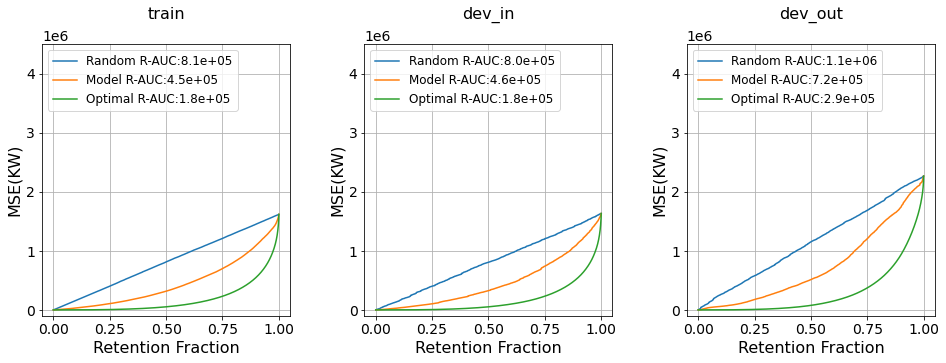

In [17]:
plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace=.3, hspace=.4)

for i, partition in enumerate(["train", "dev_in", "dev_out"]):
    plt.subplot(1, 3, i + 1)
    get_comparison_error_retention_plot(error=sqr_errors[partition],
                                        uncertainty=uncertainties[partition]["tvar"])
    plt.ylabel('MSE(KW)')
    plt.xlabel("Retention Fraction")
    plt.legend(loc="upper left", prop={"size": 12})
    plt.title(partition, pad=25)
    plt.ylim(-0.1e6, 4.5e6)
    plt.grid()

plt.show()
plt.close()

# F1 retention curves

#### Define threshold of acceptable errors

In [18]:
# Use an acceptable error threshold of (500 kW)^2
thresh = 500 ** 2

#### Plot F1 retentions

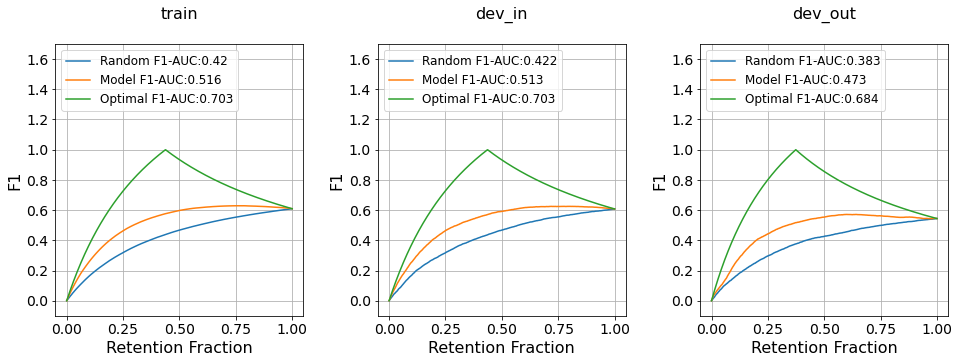

In [19]:
plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace=.3, hspace=.4)

for i, partition in enumerate(["train", "dev_in", "dev_out"]):
    plt.subplot(1, 3, i + 1)
    get_comparison_f1_retention_plot(error=sqr_errors[partition],
                                     uncertainty=uncertainties[partition]["tvar"],
                                     threshold=thresh)
    plt.legend(loc="upper left", prop={"size": 12})
    plt.ylabel('F1')
    plt.xlabel("Retention Fraction")
    plt.title(partition, pad=25)
    plt.ylim(-0.1, 1.7)
    plt.grid()

plt.show()
plt.close()

# Predictive performance Tables

In [20]:
table = [["Data", "RMSE Ens. (KW)", "MAE Ens. (KW)", "MAPE (%)"]]

for k in data_all_ds.keys():
    rmse_metric = get_ensemble_metric(pred=predictions[k]["denorm"], y_true=data_all_ds[k].full_df[target], metric="rmse")
    mae_metric = get_ensemble_metric(pred=predictions[k]["denorm"], y_true=data_all_ds[k].full_df[target], metric="mae")
    mape_metric = get_ensemble_metric(pred=predictions[k]["denorm"], y_true=data_all_ds[k].full_df[target], metric="mape")

    results = [k,
               np.round(rmse_metric, 0),
               np.round(mae_metric, 0),
               np.round(100 * mape_metric, 2)]
    table.append(results)

print("Classic metrics")
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

Classic metrics
╒═════════╤══════════════════╤═════════════════╤════════════╕
│ Data    │   RMSE Ens. (KW) │   MAE Ens. (KW) │   MAPE (%) │
╞═════════╪══════════════════╪═════════════════╪════════════╡
│ train   │             1271 │             860 │       5.5  │
├─────────┼──────────────────┼─────────────────┼────────────┤
│ dev_in  │             1277 │             863 │       5.42 │
├─────────┼──────────────────┼─────────────────┼────────────┤
│ dev_out │             1505 │            1065 │       7.4  │
├─────────┼──────────────────┼─────────────────┼────────────┤
│ dev     │             1396 │             964 │       6.41 │
╘═════════╧══════════════════╧═════════════════╧════════════╛


In [21]:
table = [["Data", "R-AUC", "F1-AUC", "F1 @ 95 %"]]

for k in data_all_ds.keys():
    r = sqr_errors[k]
    var = uncertainties[k]["tvar"]

    rejection_mse = calc_uncertainty_regection_curve(errors=r, uncertainty=var, group_by_uncertainty=False)
    retention_mse = rejection_mse[::-1]
    retention_fractions = np.linspace(0, 1, len(retention_mse))
    roc_auc = auc(x=retention_fractions[::-1], y=retention_mse)

    f_auc, f95, retention_f1 = f_beta_metrics(errors=r,
                                              uncertainty=var,
                                              threshold=thresh,
                                              beta=1.0)
    results = [k,
               roc_auc,
               np.round(f_auc, 3),
               np.round(f95, 3)]
    table.append(results)

print("AUCs")
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

AUCs
╒═════════╤═════════╤══════════╤═════════════╕
│ Data    │   R-AUC │   F1-AUC │   F1 @ 95 % │
╞═════════╪═════════╪══════════╪═════════════╡
│ train   │  445887 │    0.516 │       0.617 │
├─────────┼─────────┼──────────┼─────────────┤
│ dev_in  │  462008 │    0.513 │       0.615 │
├─────────┼─────────┼──────────┼─────────────┤
│ dev_out │  724512 │    0.473 │       0.545 │
├─────────┼─────────┼──────────┼─────────────┤
│ dev     │  611374 │    0.491 │       0.582 │
╘═════════╧═════════╧══════════╧═════════════╛
